In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Utils import Read_data as Rd
import statsmodels.api as sm
from Utils import Plot as pl
import scipy.optimize

In [41]:
path = "DataPaper/"
users = os.listdir(path)

In [42]:
df_sleep = Rd.create_dataset(users, 'sleep')
df_sleep['user'].iloc[1] = 'user_11'
df_sleep.head()

C:\Users\anisr\AppData\Local\Temp\ipykernel_12652\2307410697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep['user'].iloc[1] = 'user_11'


,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index,user
0,2,00:46,2,03:31,2,00:46,NaN,87.27,165,144,21,9,2.33,9.091,10.000,19.091,user_1
1,2,03:57,2,07:30,2,03:57,NaN,92.02,213,196,17,9,1.89,8.920,NaN,8.920,user_11
0,2,02:40,2,08:09,2,02:44,4.0,75.08,329,247,78,13,6.00,20.669,7.692,28.361,user_10
0,2,00:32,2,06:36,2,00:32,NaN,94.23,364,343,21,12,1.75,9.066,15.385,24.451,user_12
0,1,23:41,1,05:04,1,23:41,NaN,76.47,323,247,76,19,4.00,17.957,15.789,33.746,user_13


In [43]:
df_sleep['In Bed Time'] = [
    int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_sleep['In Bed Time']]
df_sleep['In Bed Time'] = [x-24*60 if x > 20 *
                           60 else x for x in df_sleep['In Bed Time']]

df_sleep['Out Bed Time'] = [
    int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_sleep['Out Bed Time']]
df_sleep['Out Bed Time'] = [x-24*60 if x > 20 *
                            60 else x for x in df_sleep['Out Bed Time']]

df_sleep['Onset Time'] = [
    int(x.split(':')[0])*60+int(x.split(':')[1])for x in df_sleep['Onset Time']]
df_sleep['Onset Time'] = [x-24*60 if x > 20 *
                          60 else x for x in df_sleep['Onset Time']]

df_sleep = df_sleep.fillna(0)

In [44]:
df_activity = Rd.create_dataset(users, 'activity')

In [45]:
df_activity

,Activity,Start,End,Day,user
0,2.0,10:00,10:22,1,user_1
1,9.0,10:37,10:40,1,user_1
2,10.0,10:40,10:45,1,user_1
3,6.0,10:55,11:00,1,user_1
4,2.0,11:00,11:20,1,user_1
...,...,...,...,...,...
14,1.0,05:15,05:25,2,user_9
15,NaN,05:25,09:00,2,user_9
16,6.0,11:10,11:20,1,user_9
17,12.0,23:30,23:40,1,user_9


In [46]:
df_activity['End'] = df_activity['End'].replace('24:00', '00:00')

df_activity['Start'] = pd.to_datetime(df_activity['Start'], format='%H:%M')
df_activity['End'] = pd.to_datetime(df_activity['End'], format='%H:%M')

df_activity['End'] = df_activity.apply(
    lambda row: row['End'] +
    pd.Timedelta(days=1) if row['End'] < row['Start'] else row['End'],
    axis=1
)

df_activity['Time Spent'] = (
    df_activity['End'] - df_activity['Start']).dt.total_seconds() / 60

df_activity = df_activity.drop(columns=['Start', 'End', 'Day'])

In [47]:
df_activity

,Activity,user,Time Spent
0,2.0,user_1,22.0
1,9.0,user_1,3.0
2,10.0,user_1,5.0
3,6.0,user_1,5.0
4,2.0,user_1,20.0
...,...,...,...
14,1.0,user_9,10.0
15,NaN,user_9,215.0
16,6.0,user_9,10.0
17,12.0,user_9,10.0


In [48]:
dict_activity = {0: 'sleeping',
                 1: 'laying down',
                 2: 'sitting',
                 3: 'light movement',
                 4: 'medium movement',
                 5: 'heavy movement',
                 6: 'eating',
                 7: 'small screen usage',
                 8: 'large screen',
                 9: 'coffee/coke',
                 10: 'smoking',
                 11: 'alcohol assumption',
                 12: 'saliva samples'}

df_activity['Activity'] = df_activity['Activity'].replace(
    dict_activity) 
df_activity

,Activity,user,Time Spent
0,sitting,user_1,22.0
1,coffee/coke,user_1,3.0
2,smoking,user_1,5.0
3,eating,user_1,5.0
4,sitting,user_1,20.0
...,...,...,...
14,laying down,user_9,10.0
15,NaN,user_9,215.0
16,eating,user_9,10.0
17,saliva samples,user_9,10.0


In [49]:
df_activity[(df_activity['user']=='user_1') & (df_activity['Activity']=='coffee/coke')]

,Activity,user,Time Spent
1,coffee/coke,user_1,3.0
10,coffee/coke,user_1,5.0
24,coffee/coke,user_1,5.0


In [50]:
df_activity.groupby(['user','Activity']).sum()

Time Spent
user   Activity                      
user_1 coffee/coke               13.0
       eating                   130.0
       heavy movement            10.0
       large screen              45.0
       laying down                5.0
...                               ...
user_9 laying down               10.0
       light movement          1340.0
       saliva samples            20.0
       sitting                   10.0
       small screen usage       360.0

[152 rows x 1 columns]

In [51]:
df_activity = df_activity.groupby(['user', 'Activity']).sum().reset_index()

In [52]:
df_activity 

,user,Activity,Time Spent
0,user_1,coffee/coke,13.0
1,user_1,eating,130.0
2,user_1,heavy movement,10.0
3,user_1,large screen,45.0
4,user_1,laying down,5.0
...,...,...,...
147,user_9,laying down,10.0
148,user_9,light movement,1340.0
149,user_9,saliva samples,20.0
150,user_9,sitting,10.0


In [53]:
df_merged = pd.merge(df_sleep, df_activity, on='user')
print(df_merged.shape)

(152, 19)


In [54]:
df_merged.head()

,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index,user,Activity,Time Spent
0,2,46,2,211,2,46,0.0,87.27,165,144,21,9,2.33,9.091,10.0,19.091,user_1,coffee/coke,13.0
1,2,46,2,211,2,46,0.0,87.27,165,144,21,9,2.33,9.091,10.0,19.091,user_1,eating,130.0
2,2,46,2,211,2,46,0.0,87.27,165,144,21,9,2.33,9.091,10.0,19.091,user_1,heavy movement,10.0
3,2,46,2,211,2,46,0.0,87.27,165,144,21,9,2.33,9.091,10.0,19.091,user_1,large screen,45.0
4,2,46,2,211,2,46,0.0,87.27,165,144,21,9,2.33,9.091,10.0,19.091,user_1,laying down,5.0


In [55]:
for activity in df_merged['Activity'].unique():
    df_activity_subset = df_merged[df_merged['Activity'] == activity]
    X = df_activity_subset['Time Spent']
    y = df_activity_subset['Total Sleep Time (TST)']

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(f"Activity: {activity}")
    print(model.summary())

Activity: coffee/coke
                              OLS Regression Results                              
Dep. Variable:     Total Sleep Time (TST)   R-squared:                       0.143
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     2.341
Date:                    Tue, 10 Dec 2024   Prob (F-statistic):              0.148
Time:                            19:47:41   Log-Likelihood:                -87.747
No. Observations:                      16   AIC:                             179.5
Df Residuals:                          14   BIC:                             181.0
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

C:\Users\anisr\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\anisr\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\anisr\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\anisr\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\anisr\anaconda3\envs\work\lib\site-packages\statsmodels\stats\statto

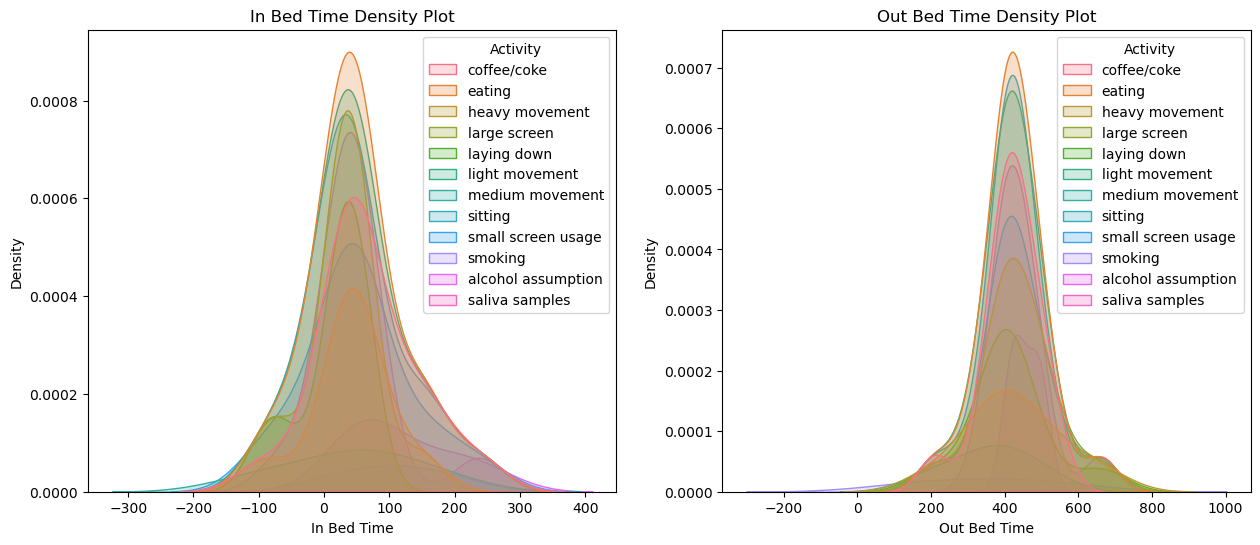

In [56]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df_merged, x='In Bed Time',
            hue='Activity', ax=axes[0], fill=True)
axes[0].set_title('In Bed Time Density Plot')

sns.kdeplot(data=df_merged, x='Out Bed Time',
            hue='Activity', ax=axes[1], fill=True)
axes[1].set_title('Out Bed Time Density Plot')

plt.show()

In [77]:
df_merged['Difference'] = abs(
    df_merged['In Bed Time'] - df_merged['Onset Time'])
max_difference_row = df_merged.loc[df_merged['Difference'].idxmax()]

In [78]:
activity_with_max_difference = max_difference_row['Activity']
max_difference_value = max_difference_row['Difference']

In [79]:
print(
    f"The activity with the highest difference between 'In Bed Time' and 'Onset Time' is: {activity_with_max_difference}")
print(f"The highest difference value is: {max_difference_value}")

The activity with the highest difference between 'In Bed Time' and 'Onset Time' is: alcohol assumption
The highest difference value is: 4


In [86]:
difference = df_merged[df_merged['Difference'] > 0].sort_values(by='Difference', ascending=False)

In [99]:
top5 = difference.drop_duplicates(subset='user').iloc[:5]

In [100]:
columns_of_interest = ['user', 'Activity', 'Difference', 'Latency', 'Efficiency', 'Total Minutes in Bed',
                       'Total Sleep Time (TST)', 'Wake After Sleep Onset (WASO)', 'Number of Awakenings', 'Average Awakening Length', 'Movement Index', 'Fragmentation Index', 'Sleep Fragmentation Index']

top_5_analysis = top5[columns_of_interest]

In [102]:
top_5_analysis

,user,Activity,Difference,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
17,user_10,alcohol assumption,4,4.0,75.08,329,247,78,13,6.00,20.669,7.692,28.361
55,user_16,sitting,4,4.0,74.34,456,339,113,39,2.90,16.228,15.385,31.613
79,user_2,eating,4,4.0,73.49,332,244,84,18,4.67,15.060,5.556,20.616
113,user_4,coffee/coke,4,4.0,85.52,373,319,50,28,1.79,8.847,14.286,23.133
140,user_8,large screen,3,3.0,80.77,416,336,77,27,2.85,17.308,25.926,43.234


In [103]:
X = top_5_analysis.drop(columns=['user', 'Activity', 'Difference'])
y = top_5_analysis['Difference']

In [104]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

feature_importance = pd.Series(
    model.coef_, index=X.columns).sort_values(ascending=False)

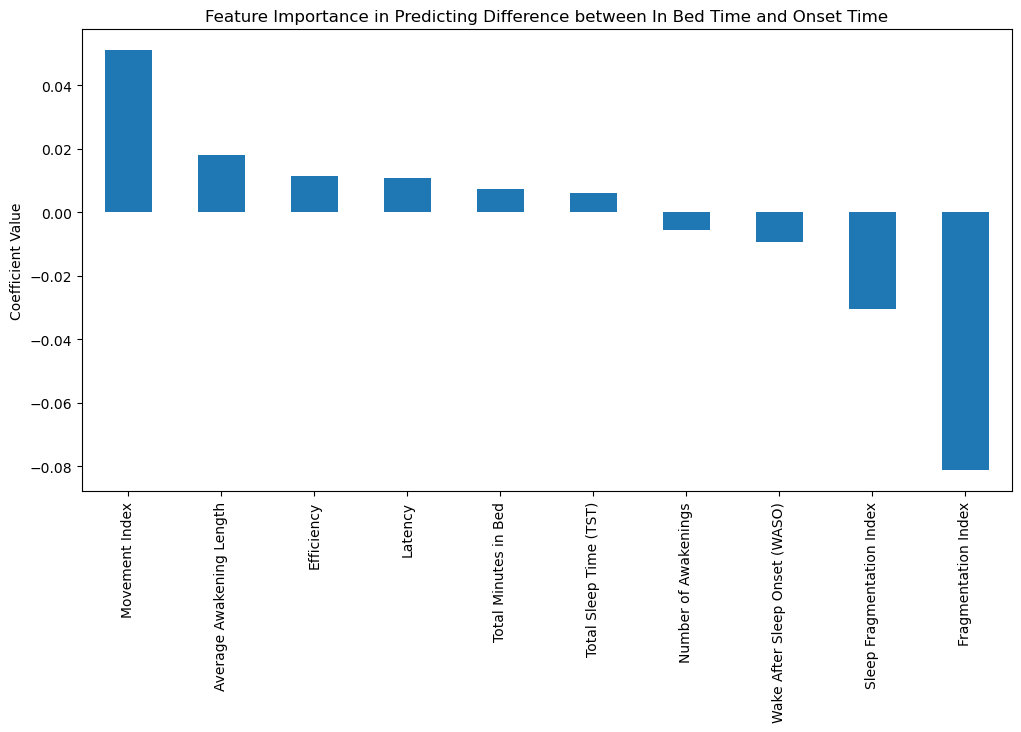

In [105]:
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title(
    'Feature Importance in Predicting Difference between In Bed Time and Onset Time')
plt.ylabel('Coefficient Value')
plt.show()

In [106]:
print(feature_importance)

Movement Index                   0.050999
Average Awakening Length         0.018149
Efficiency                       0.011475
Latency                          0.010921
Total Minutes in Bed             0.007417
Total Sleep Time (TST)           0.005955
Number of Awakenings            -0.005518
Wake After Sleep Onset (WASO)   -0.009459
Sleep Fragmentation Index       -0.030307
Fragmentation Index             -0.081306
dtype: float64
